## Imports

In [66]:
from src.tokenizer import Tokenizer, normalize_text
from src.vis import plot_attention

from typing import Tuple
import random
import numpy as np
import pytest

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import evaluate

import matplotlib.pyplot as plt
import jupyter_black

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

jupyter_black.load()
%matplotlib inline

## Dataset

In [67]:
src_tok: Tokenizer = torch.load("data/src_tok.pt")
tgt_tok: Tokenizer = torch.load("data/tgt_tok.pt")
vocab_size = src_tok.vocab_size
pad_token_ix = src_tok.wtoi[src_tok.pad_token]
print(f"Vocab size: {vocab_size}")
print(f"Pad token index: {pad_token_ix}")

Vocab size: 512
Pad token index: 0


In [68]:
train_dl: DataLoader = torch.load("data/train_dl.pt")
val_dl: DataLoader = torch.load("data/val_dl.pt")
test_dl: DataLoader = torch.load("data/test_dl.pt")
tiny_train_dl: DataLoader = torch.load("data/tiny_train_dl.pt")

## Model Architecture

### Scaled Dot Product Attention

#### Architecture

In [69]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        """
        :param queries: (N, M, D) where M is the number of queries and D is the dimension of the query
        :param keys: (N, T, D) where T is the number of keys
        :param values: (N, T, V) where V is the dimension of the value
        :param mask: (N, M, T) where T is the number of keys
        :return: (N, M, V)
        """
        _, _, D = queries.shape
        # (N, M, D) @ (N, D, T) -> (N, M, T)
        self.logits = queries @ keys.transpose(1, 2) * D**-0.5
        # Mask logits at indices < valid lens
        if mask is not None:
            self.logits = self.logits.masked_fill(mask == 0, float("-inf"))
        self.attn_weights = F.softmax(self.logits, dim=-1)  # (N, M, T)
        self.attn_weights = self.dropout(self.attn_weights)
        return self.attn_weights @ values  # (N, M, T) @ (N, T, V) -> (N, M, V)

#### Testing Scaled Dot Product Attention

In [70]:
N, M, T, D, V = 2, 3, 4, 5, 6
queries = torch.ones(N, M, D)
keys = torch.ones(N, T, D)
values = torch.ones(N, T, V)

attn = ScaledDotProductAttention()
context = attn.forward(queries, keys, values)
context.shape, context.shape == (N, M, V)

(torch.Size([2, 3, 6]), True)

In [71]:
# Self-attention
X = next(iter(tiny_train_dl))[0]
emb_ = nn.Embedding(vocab_size, 16).to(device)
emb = emb_(X)  # (N, T, D)

attn = ScaledDotProductAttention(dropout=0.0)
context = attn.forward(emb, emb, emb)
context.shape, context.shape == emb.shape

(torch.Size([5, 12, 16]), True)

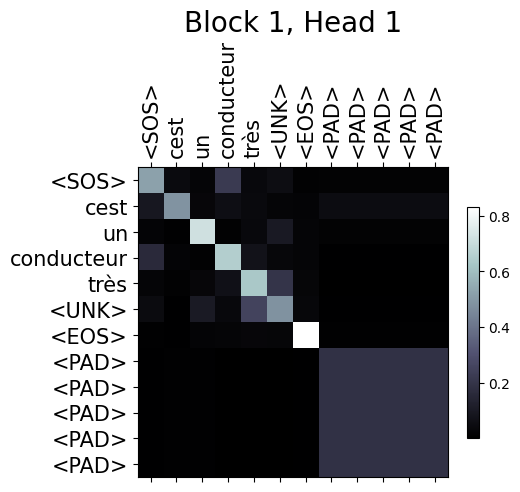

In [72]:
ix = 2
sent = src_tok.untokenize(X[ix].detach().tolist(), remove_padding_tokens=False).split()
plot_attention(sentence=sent, translation=sent, attention=attn.attn_weights[ix])

In [73]:
# Masked Self-Attention
X = next(iter(tiny_train_dl))[0]
mask = (X != pad_token_ix).type(torch.long).unsqueeze(1)  # (N, 1, T)

emb_ = nn.Embedding(vocab_size, 16).to(device)
emb = emb_(X)  # (N, T, D)

attn = ScaledDotProductAttention()
context = attn.forward(emb, emb, emb, mask=mask)
context.shape, context.shape == emb.shape

(torch.Size([5, 12, 16]), True)

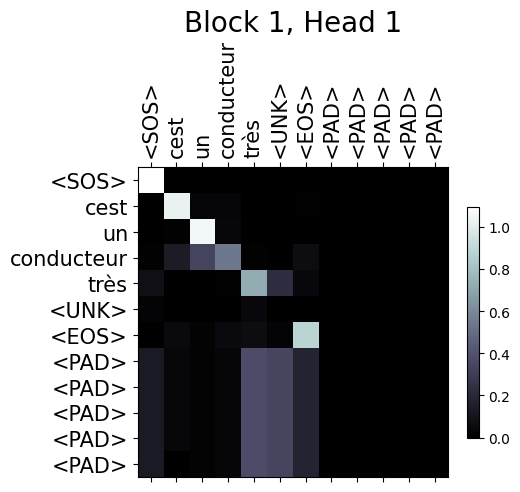

In [74]:
ix = 2
sent = src_tok.untokenize(X[ix].detach().tolist(), remove_padding_tokens=False).split()
plot_attention(sentence=sent, translation=sent, attention=attn.attn_weights[ix])

### Multi-Head Attention

#### Architecture

In [75]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, head_size, num_heads, dropout=0.1):
        """
        :param emb_size: dimension of the token embeddings
        :param head_size: dimension of each attention head
        :param num_heads: number of heads
        :param dropout: dropout rate
        """
        super().__init__()
        self.E = num_heads
        self.attention = ScaledDotProductAttention()
        # Input projection into attention
        self.hidden_size = head_size * num_heads
        self.Q = nn.Linear(emb_size, self.hidden_size, bias=False)
        self.K = nn.Linear(emb_size, self.hidden_size, bias=False)
        self.V = nn.Linear(emb_size, self.hidden_size, bias=False)
        # Output projection
        self.O = nn.Linear(self.hidden_size, emb_size)
        self.dropout = nn.Dropout(dropout)

    def transpose_input(self, X):
        """
        Transpose QKV inputs to fit number of heads
        :param X: (N, T, H) where T is the number of tokens and H is the dimension of the token
        :return: (N*E, T, H//E)
        """
        E = self.E
        N, T, H = X.shape
        X = X.reshape(N, T, E, -1)  # (N, T, E, H // E)
        X = X.transpose(1, 2)  # (N, E, T, H//E)
        X = X.reshape(N * E, T, -1)  # (N*E, T, H//E)
        return X

    def transpose_output(self, X):
        """
        Transpose attention output back to original
        shape
        :param X: (N*E, T, H//E)
        :return: (N, T, H)
        """
        E = self.E
        NE, T, H_E = X.shape
        X = X.reshape(-1, E, T, H_E)  # (N, E, T, H//E)
        X = X.transpose(1, 2)  # (N, T, E, H//E)
        X = X.reshape(-1, T, H_E * E)  # (N, T, H)
        return X

    def forward(self, queries, keys, values, mask=None):
        """
        :param queries: (N, M, D) where M is the number of queries and H is the dimension of the query
        :param keys: (N, T, D) where T is the number of keys
        :param values: (N, T, D)
        :param mask: (N, M, T)
        """
        # Project QKV into matrices which can fit into each attention head
        query = self.transpose_input(
            self.Q(queries)
        )  # (N, M, D) -> (N, M, H) -> (N*E, M, H//E)
        key = self.transpose_input(
            self.K(keys)
        )  # (N, T, D) -> (N, T, H) -> (N*E, T, H//E)
        value = self.transpose_input(self.V(values))  # (N*E, T, H//E)

        # Copy mask for all heads
        if mask is not None:
            mask = mask.repeat_interleave(self.E, dim=0)  # (N*E, M, T)

        # Now we can fit E copies of our N samples through a single attention head
        # and have it essentially emulate having multiple attention heads
        context = self.attention.forward(
            queries=query,
            keys=key,
            values=value,
            mask=mask,
        )  # (N*E, M, H//E)

        # Concatenate head outputs back into a single tensor, pass through Linear layer
        out = self.transpose_output(context)  # (N, M, H)
        return self.dropout(self.O(out))

#### Testing Multi-Head Attention

In [76]:
N, M, T = 2, 3, 4
H, E = 8, 2
queries = torch.ones(N, M, H)
keys = torch.ones(N, T, H)
values = torch.ones(N, T, H)

attn = MultiHeadAttention(emb_size=H, head_size=H, num_heads=E)
context = attn.forward(queries, keys, values)
context.shape, context.shape == (N, M, H)

(torch.Size([2, 3, 8]), True)

In [77]:
# Masked Multi-Head Self-Attention
H, E = 16, 4
X = next(iter(tiny_train_dl))[0]
N, T = X.shape
mask = (X != pad_token_ix).type(torch.long).unsqueeze(1)

emb_ = nn.Embedding(vocab_size, H).to(device)
emb = emb_(X)  # (N, T, D)

attn = MultiHeadAttention(emb_size=H, head_size=H, num_heads=E).to(device)
context = attn.forward(emb, emb, emb, mask=mask)
context.shape, context.shape == emb.shape

(torch.Size([5, 12, 16]), True)

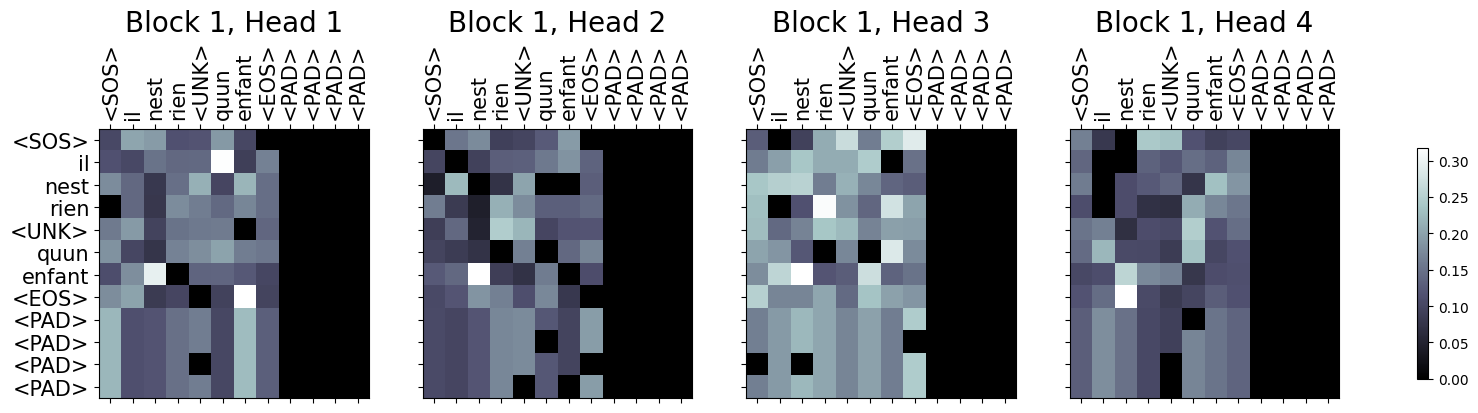

In [78]:
attn_weights = attn.attention.attn_weights.view(-1, E, T, T)  # (N, E, M, T)
ix = 0
sent = src_tok.untokenize(X[ix].detach().tolist(), remove_padding_tokens=False).split()
plot_attention(sentence=sent, translation=sent, attention=attn_weights[ix])

### Positional Encoding

#### Architecture

In [79]:
class PositionalEncoding(nn.Module):
    def __init__(self, hidden_size, dropout, max_len=1000):
        """
        hidden_size: dimension `d_model` with indices `i`
        max_len: position `pos`
        """
        super().__init__()
        self.d_model = hidden_size
        self.pos = max_len
        # Our positional encoding tensor
        self.P = torch.zeros(1, self.pos, self.d_model)
        # Declare the inputs to the trig functions of the pos encoding
        self.numerator = torch.arange(self.pos, dtype=torch.float32).unsqueeze(
            1
        )  # (I, 1)
        self.denominator = torch.pow(
            10000,
            torch.arange(0, self.d_model, 2, dtype=torch.float32) / self.d_model,
        )
        X = self.numerator / self.denominator
        # Assign trig functions to alternating even and odd dimensions of each position
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
        # Set dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, X):
        """
        X: (N, T, D)
        We add the positional encoding to each sample of X
        """
        _, T, _ = X.shape
        # Limit our addition of the positional encoding up to the timestep dimension T
        X += self.P[:, :T].to(X.device)
        return self.dropout(X)

#### Testing Positional Encoding

In [80]:
D, T = 32, 60
dropout = 0.1
pos_encoding = PositionalEncoding(hidden_size=D, dropout=dropout)
X = pos_encoding(torch.zeros(1, T, D))
P = pos_encoding.P[:, :T]
X.shape, P.shape

(torch.Size([1, 60, 32]), torch.Size([1, 60, 32]))

In [81]:
# Masked Multi-Head Self-Attention
H, E = 16, 4
X = next(iter(tiny_train_dl))[0]
N, T = X.shape
mask = (X != pad_token_ix).type(torch.long).unsqueeze(1)

emb_ = nn.Embedding(vocab_size, H).to(device)
emb = emb_(X)  # (N, T, D)

pos_ = PositionalEncoding(hidden_size=H, dropout=0.1).to(device)
emb_and_pos = pos_(emb)

attn = MultiHeadAttention(emb_size=H, head_size=H, num_heads=E).to(device)
context = attn.forward(emb_and_pos, emb_and_pos, emb_and_pos, mask=mask)
context.shape, context.shape == emb_and_pos.shape

(torch.Size([5, 12, 16]), True)

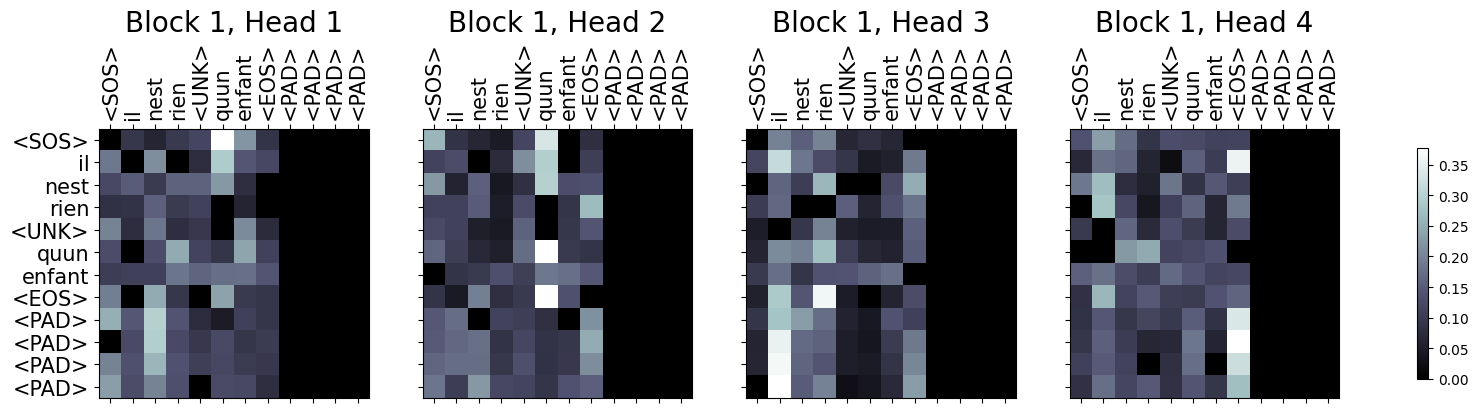

In [82]:
attn_weights = attn.attention.attn_weights.view(-1, E, T, T)  # (N, E, M, T)
ix = 0
sent = src_tok.untokenize(X[ix].detach().tolist(), remove_padding_tokens=False).split()
plot_attention(sentence=sent, translation=sent, attention=attn_weights[ix])

### Feed Forward

#### Architecture

In [83]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Dropout(dropout),
        )

    def forward(self, X):
        """
        X: (N, T, D)
        output: (N, T, O)
        """
        # lin1 -> relu -> lin2
        return self.net(X)  # (N, T, O)

### Residual + Layer Norm

#### Architecture

In [84]:
class AddNorm(nn.Module):
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        """
        X: (N, T, H)
        Y: (N, T, H)
        Dropout -> Residual addition -> Layer norm
        """
        return self.ln(self.dropout(Y) + X)

#### Testing Residual + Layer Norm

In [85]:
N, T, H = 2, 3, 4
an = AddNorm(H, 0.5)
X, Y = torch.ones(N, T, H), torch.ones(N, T, H)
out = an(X, Y)
out.shape, out.shape == (N, T, H)

(torch.Size([2, 3, 4]), True)

In [86]:
# Masked Multi-Head Self-Attention
H, E = 16, 4
X = next(iter(tiny_train_dl))[0]
N, T = X.shape
mask = (X != pad_token_ix).type(torch.long).unsqueeze(1)

emb_ = nn.Embedding(vocab_size, H).to(device)
emb = emb_(X)  # (N, T, D)

pos_ = PositionalEncoding(hidden_size=H, dropout=0.1).to(device)
emb_and_pos = pos_(emb)

attn = MultiHeadAttention(emb_size=H, head_size=H, num_heads=E).to(device)
context = attn.forward(emb_and_pos, emb_and_pos, emb_and_pos, mask=mask)
print(context.shape, context.shape == emb_and_pos.shape)

an = AddNorm(H, 0.5).to(device)
out = an(emb_and_pos, context)
print(out.shape, out.shape == emb_and_pos.shape)

torch.Size([5, 12, 16]) True
torch.Size([5, 12, 16]) True


### Encoder Block

- Multi-head self-attention
- AddNorm
- PositionWiseLinear
- AddNorm

#### Architecture

In [87]:
class TransformerEncoderBlock(nn.Module):
    def __init__(
        self,
        emb_size,
        head_size,
        mlp_hidden_size,
        num_heads,
        dropout,
    ):
        """
        :param emb_size: dimension of the token embeddings
        :param head_size: dimension of each attention head
        :param mlp_hidden_size: hidden size of the Position-wise Linear block
        :param num_heads: Number of attention heads
        :param dropout: Dropout for AddNorm blocks
        """
        super().__init__()
        self.attention = MultiHeadAttention(
            emb_size=emb_size,
            head_size=head_size,
            num_heads=num_heads,
            dropout=dropout,
        )
        self.an1 = AddNorm(norm_shape=emb_size, dropout=dropout)
        self.mlp = MLP(
            input_size=emb_size, hidden_size=mlp_hidden_size, output_size=emb_size
        )
        self.an2 = AddNorm(norm_shape=emb_size, dropout=dropout)

    def forward(self, X, mask=None):
        """
        :param X: (N, T, D) emb + pos encoded tensor
        :param mask: (N, T, T) mask tensor
        :return: (N, T, D) output tensor
        """
        Y = self.an1(X, self.attention.forward(X, X, X, mask))
        return self.an2(Y, self.mlp.forward(Y))  # (N, T, D)

#### Testing the Encoder Block

In [88]:
# Masked Multi-Head Self-Attention
D, H, E = 16, 32, 4
dropout = 0.1
X = next(iter(tiny_train_dl))[0]
N, T = X.shape
mask = (X != pad_token_ix).type(torch.long).unsqueeze(1)  # (N, 1, T)

emb_ = nn.Embedding(vocab_size, D).to(device)
emb = emb_(X)  # (N, T, D)

pos_ = PositionalEncoding(hidden_size=D, dropout=dropout).to(device)
emb_and_pos = pos_(emb)

"""1 Encoder Block"""

block = TransformerEncoderBlock(
    emb_size=D,
    head_size=D,
    mlp_hidden_size=H,
    num_heads=E,
    dropout=dropout,
).to(device)
enc_out = block.forward(emb_and_pos, mask=mask)
enc_out.shape, enc_out.shape == (N, T, D)

(torch.Size([5, 12, 16]), True)

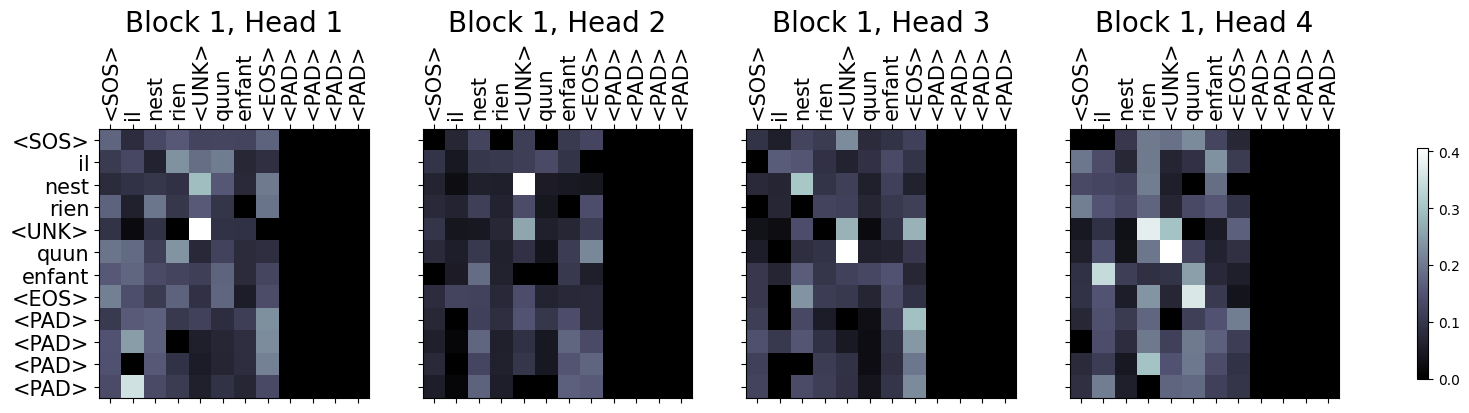

In [89]:
attn_weights = block.attention.attention.attn_weights.view(-1, E, T, T)  # (N, E, M, T)
ix = 0
sent = src_tok.untokenize(X[ix].detach().tolist(), remove_padding_tokens=False).split()
plot_attention(sentence=sent, translation=sent, attention=attn_weights[ix])

### Encoder

- Embedding + Positional Encoding
- Nx Encoder Blocks

In [90]:
class TransformerEncoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        emb_size: int,
        head_size: int,
        mlp_hidden_size: int,
        num_heads: int,
        num_blocks: int,
        dropout: float,
    ):
        """
        :param vocab_size: size of the vocabulary
        :param emb_size: dimension of the token embeddings
        :param head_size: dimension of each attention head
        :param mlp_hidden_size: hidden size of the Position-wise Linear block
        :param num_heads: Number of attention heads
        :param num_blocks: Number of encoder blocks
        :param dropout: Dropout float value
        """
        super().__init__()
        self.D = emb_size
        self.H = head_size
        self.E = num_heads
        self.B = num_blocks
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.pos = PositionalEncoding(emb_size, dropout)
        self.blocks = nn.Sequential()
        for i in range(num_blocks):
            self.blocks.add_module(
                name=f"block{i}",
                module=TransformerEncoderBlock(
                    emb_size=emb_size,
                    head_size=head_size,
                    mlp_hidden_size=mlp_hidden_size,
                    num_heads=num_heads,
                    dropout=dropout,
                ),
            )
        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, X, mask=None):
        """
        :param X: (N, T) input tensor
        :param mask: (N, T, T) mask tensor
        """
        N, T = X.shape
        # Rescale embedding values during positional encoding
        # using sqrt of the fan-in
        X = self.pos(self.emb(X) * self.D**0.5)  # (N, T, D)
        self.attn_weights = torch.zeros((N, self.B, self.E, T, T), device=X.device)
        # Send the embedded/encoded tensor through each encoder block
        # The idea is that through each block, a more complex representation of the
        # input samples is learned
        for i, block in enumerate(self.blocks):
            X = block(X, mask)
            self.attn_weights[
                :, i : i + 1
            ] = block.attention.attention.attn_weights.view(N, -1, T, T).unsqueeze(
                1
            )  # (N, 1, E, T, T)
        return X  # (N, T, D)

#### Testing the Encoder

In [91]:
# Masked Multi-Head Self-Attention
D, H, E, B, C = 16, 32, 4, 1, 2
dropout = 0.1
X = next(iter(tiny_train_dl))[0]
N, T = X.shape
mask = (X != pad_token_ix).type(torch.long).unsqueeze(1)  # (N, 1, T)

enc = TransformerEncoder(
    vocab_size=vocab_size,
    emb_size=D,
    head_size=D,
    mlp_hidden_size=H,
    num_heads=E,
    num_blocks=B,
    dropout=dropout,
).to(device)
enc_out = enc.forward(X, mask)
enc_out.shape, enc_out.shape == (N, T, D)

(torch.Size([5, 12, 16]), True)

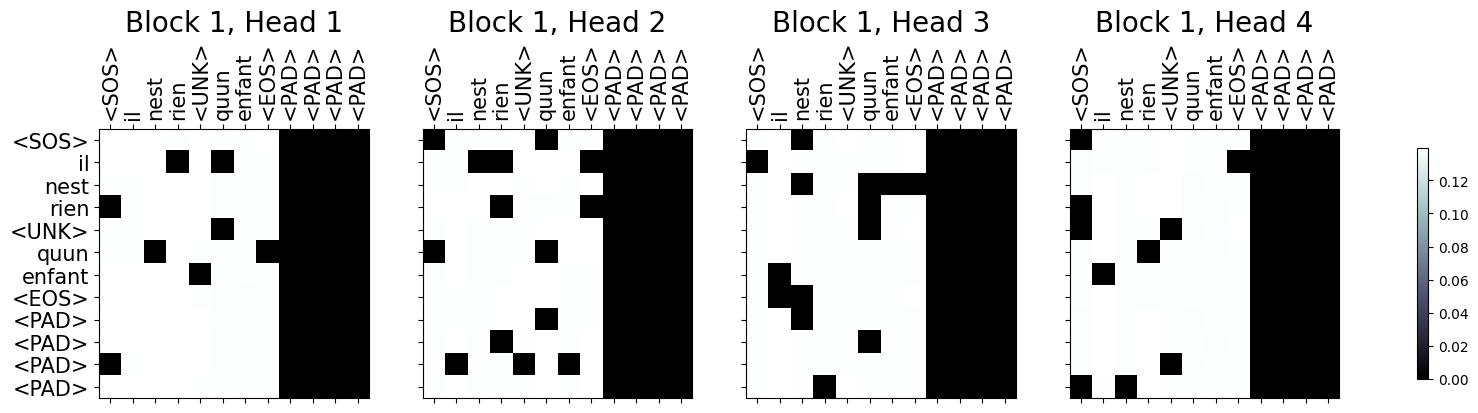

In [92]:
# Attention weights are all uniform due to the gaussian weight initialization
ix = 0
sent = src_tok.untokenize(X[ix].detach().tolist(), remove_padding_tokens=False).split()
plot_attention(sentence=sent, translation=sent, attention=enc.attn_weights[ix])

### Decoder Block

- Multi-head self-attention
- AddNorm
- Encoder-Decoder attention
- AddNorm
- MLP
- AddNorm

#### Tril + Padding Mask

The decoder block embeddings need to be blind to any token embeddings in front of it,
so a lower-triangular matrix is used as the mask.

In addition, we still want to mask out any `<PAD>` tokens, so by taking the bitwise `AND`
of both matrices, we keep both the autoregressive properties of the lower-triangular, and the
masking of the padding tokens.

In [93]:
X = next(iter(tiny_train_dl))[0]
N, T = X.shape
tril = torch.tril(torch.ones(100, 100)).type(torch.long).to(device)
mask = (X != pad_token_ix).type(torch.long).unsqueeze(1)  # (N, 1, T)
tril.shape, mask.shape

(torch.Size([100, 100]), torch.Size([5, 1, 12]))

In [94]:
new_mask = tril[:T, :T] & mask
new_mask[0]

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]], device='mps:0')

In [95]:
emb_ = nn.Embedding(vocab_size, H).to(device)
emb = emb_(X)  # (N, T, D)

wei = emb @ emb.transpose(-2, -1)
wei = wei.masked_fill(new_mask == 0, float("-inf"))
wei[0, -5:-1]

tensor([[-1.7520,  4.1161,  0.2014, -3.8382, -8.8741, -7.4382, -6.7019, 31.5103,
            -inf,    -inf,    -inf,    -inf],
        [ 4.3938, -9.4816,  9.7555, -2.8097,  5.4330,  1.2616,  3.8741,  0.5643,
            -inf,    -inf,    -inf,    -inf],
        [ 4.3938, -9.4816,  9.7555, -2.8097,  5.4330,  1.2616,  3.8741,  0.5643,
            -inf,    -inf,    -inf,    -inf],
        [ 4.3938, -9.4816,  9.7555, -2.8097,  5.4330,  1.2616,  3.8741,  0.5643,
            -inf,    -inf,    -inf,    -inf]], device='mps:0',
       grad_fn=<SliceBackward0>)

#### Architecture

In [96]:
class TransformerDecoderBlock(nn.Module):
    def __init__(
        self,
        emb_size,
        head_size,
        mlp_hidden_size,
        num_heads,
        dropout,
    ):
        """
        :param emb_size: dimension of the token embeddings
        :param head_size: dimension of each attention head
        :param mlp_hidden_size: hidden size of the Position-wise Linear block
        :param num_heads: Number of attention heads
        :param dropout: Dropout for AddNorm blocks
        """
        super().__init__()
        self.attn1 = MultiHeadAttention(emb_size, head_size, num_heads, dropout)
        self.an1 = AddNorm(emb_size, dropout)
        self.attn2 = MultiHeadAttention(emb_size, head_size, num_heads, dropout)
        self.an2 = AddNorm(emb_size, dropout)
        self.mlp = MLP(emb_size, mlp_hidden_size, emb_size)
        self.an3 = AddNorm(emb_size, dropout)
        # Register a lower triangular mask for the decoder self-attention
        self.register_buffer("tril", torch.tril(torch.ones(100, 100)).type(torch.long))

    def forward(
        self,
        X,
        enc_out,
        enc_mask=None,
        dec_mask=None,
    ):
        """
        :param X: (N, T, D) emb + pos encoded tensor
        :param enc_out: (N, T, D) Encoder block output
        :param enc_mask: (N, T, T) mask tensor for enc-dec attention
        :param dec_mask: (N, T, T) mask tensor for decoder block
        :return: (N, T, D) output tensor
        """
        # Get the valid lengths for the decoder sequence
        if self.training:
            _, T, _ = X.shape
            # Each time step's valid length is only as long as the sequence up to that time step
            dec_mask = self.tril[:T, :T] & dec_mask

        # Masked self-attention
        X2 = self.attn1.forward(X, X, X, dec_mask)
        Y = self.an1(X, X2)  # (N, T, D)

        # Encoder-decoder attention
        if enc_out is not None:
            Y2 = self.attn2.forward(Y, enc_out, enc_out, enc_mask)
            Z = self.an2(Y, Y2)  # (N, T, D)
        else:
            Z = Y

        return self.an3(Z, self.mlp(Z))

#### Testing the Decoder Block

In [97]:
# Masked Self-Attention
D, H, E, B = 16, 32, 4, 1
dropout = 0.1
X, Y = next(iter(tiny_train_dl))
N, T = X.shape
enc_mask = (X != pad_token_ix).type(torch.long).unsqueeze(1)  # (N, 1, T)
dec_mask = (Y != pad_token_ix).type(torch.long).unsqueeze(1)  # (N, 1, T)

enc = TransformerEncoder(
    vocab_size=vocab_size,
    emb_size=D,
    head_size=D,
    mlp_hidden_size=H,
    num_heads=E,
    num_blocks=B,
    dropout=dropout,
).to(device)
enc_out = enc.forward(X, enc_mask)
print(enc_out.shape, enc_out.shape == (N, T, D))

"""Embedding + Positional Encoding"""

emb_ = nn.Embedding(num_embeddings=V, embedding_dim=D).to(device)
emb = emb_.forward(Y)  # (N, T, D)

pos_ = PositionalEncoding(hidden_size=D, dropout=dropout).to(device)
emb_and_pos = pos_.forward(emb)  # (N, T, D)

"""1 Decoder Block"""

block = TransformerDecoderBlock(
    emb_size=D,
    head_size=H,
    mlp_hidden_size=H,
    num_heads=E,
    dropout=dropout,
).to(device)

dec_out = block.forward(emb_and_pos, enc_out, enc_mask, dec_mask)
print(dec_out.shape, dec_out.shape == (N, T, D))

torch.Size([5, 12, 16]) True
torch.Size([5, 12, 16]) True


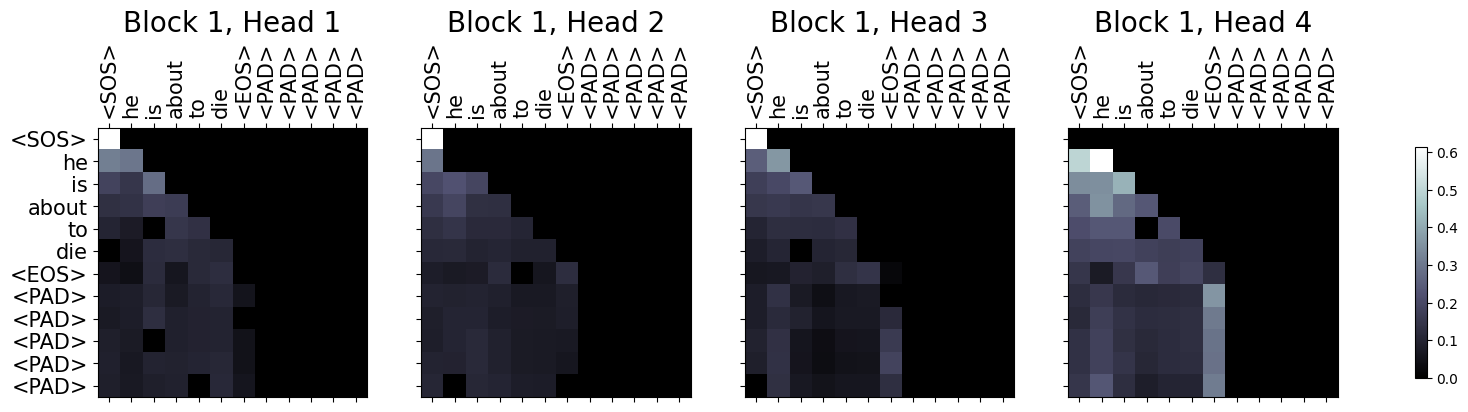

In [101]:
self_attn_weights = block.attn1.attention.attn_weights.view(-1, E, T, T)
ix = 1
sent = tgt_tok.untokenize(Y[ix].detach().tolist(), remove_padding_tokens=False).split()
plot_attention(sentence=sent, translation=sent, attention=self_attn_weights[ix])

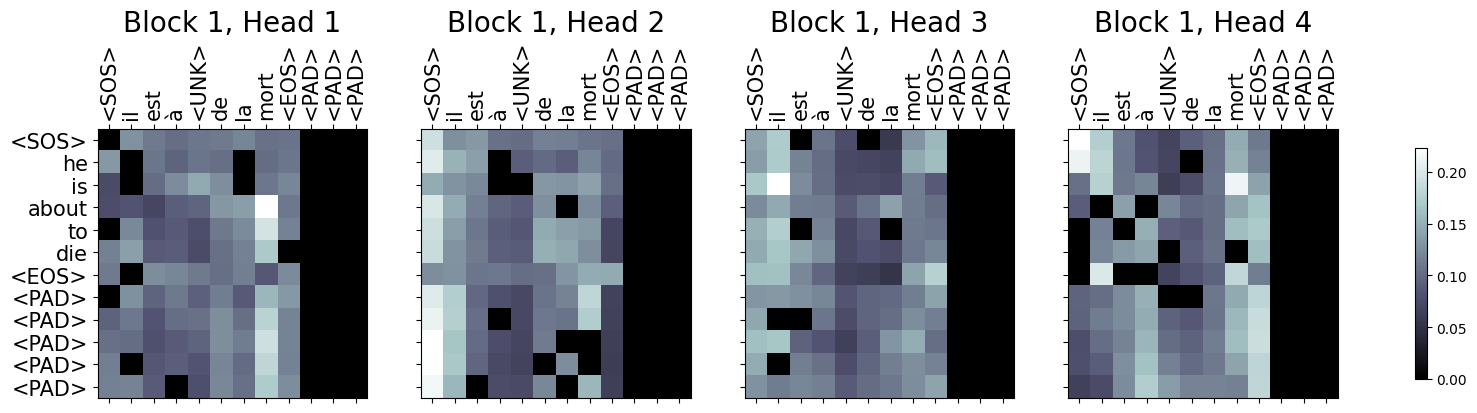

In [100]:
ed_attn_weights = block.attn2.attention.attn_weights.view(-1, E, T, T)
ix = 1
src_sent = src_tok.untokenize(
    X[ix].detach().tolist(), remove_padding_tokens=False
).split()
tgt_sent = tgt_tok.untokenize(
    Y[ix].detach().tolist(), remove_padding_tokens=False
).split()
plot_attention(sentence=src_sent, translation=tgt_sent, attention=ed_attn_weights[ix])

### Decoder

- Embedding + Positional Encoding
- Nx Decoder Blocks
- Linear projection layer to output

#### Architecture

In [103]:
class TransformerDecoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        emb_size: int,
        head_size: int,
        mlp_hidden_size: int,
        num_heads: int,
        num_blocks: int,
        dropout: float,
    ):
        """
        :param vocab_size: size of the vocabulary
        :param emb_size: dimension of the token embeddings
        :param head_size: dimension of each attention head
        :param mlp_hidden_size: hidden size of the Position-wise Linear block
        :param num_heads: Number of attention heads
        :param num_blocks: Number of decoder blocks
        :param dropout: Dropout float value
        """
        super().__init__()
        self.D = emb_size
        self.E = num_heads
        self.B = num_blocks
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.pos = PositionalEncoding(emb_size, dropout)
        self.blocks = nn.Sequential()
        for i in range(num_blocks):
            self.blocks.add_module(
                name=f"block{i}",
                module=TransformerDecoderBlock(
                    emb_size=emb_size,
                    head_size=head_size,
                    mlp_hidden_size=mlp_hidden_size,
                    num_heads=num_heads,
                    dropout=dropout,
                ),
            )
        self.lin = nn.Linear(emb_size, vocab_size)
        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, X, enc_out, enc_mask=None, dec_mask=None):
        """
        :param X: (N, T) input tensor
        :param enc_out: (N, T, D) encoder output
        :param enc_mask: (N, T, T) mask tensor for enc-dec attention
        :param dec_mask: (N, T, T) mask tensor for decoder block
        """
        N, T = X.shape
        _, encT, _ = enc_out.shape
        # Rescale embedding values during positional encoding
        # using sqrt of the fan-in
        X = self.pos(self.emb(X) * self.D**0.5)  # (N, T, D)

        self.self_attn_weights = torch.zeros((N, self.B, self.E, T, T), device=X.device)
        self.ed_attn_weights = torch.zeros(
            (N, self.B, self.E, T, encT), device=X.device
        )

        # Send the embedded/encoded tensor through each encoder block
        # The idea is that through each block, a more complex representation of the
        # input samples is learned
        for i, block in enumerate(self.blocks):
            X = block(X, enc_out, enc_mask, dec_mask)
            self.self_attn_weights[
                :, i : i + 1
            ] = block.attn1.attention.attn_weights.view(N, -1, T, T).unsqueeze(
                1
            )  # self
            self.ed_attn_weights[
                :, i : i + 1
            ] = block.attn2.attention.attn_weights.view(N, -1, T, encT).unsqueeze(
                1
            )  # enc-dec

        return self.lin(X)  # (N, T, V)

#### Test the Decoder

In [104]:
# Masked Multi-Head Self-Attention
D, H, E, B = 16, 32, 4, 1
dropout = 0.1
X, Y = next(iter(tiny_train_dl))
N, T = X.shape
enc_mask = (X != pad_token_ix).type(torch.long).unsqueeze(1)  # (N, 1, T)
dec_mask = (Y != pad_token_ix).type(torch.long).unsqueeze(1)  # (N, 1, T)

enc = TransformerEncoder(
    vocab_size=vocab_size,
    emb_size=D,
    head_size=D,
    mlp_hidden_size=H,
    num_heads=E,
    num_blocks=B,
    dropout=dropout,
).to(device)
enc_out = enc.forward(X, enc_mask)
print(enc_out.shape, enc_out.shape == (N, T, D))

dec = TransformerDecoder(
    vocab_size=vocab_size,
    emb_size=D,
    head_size=D,
    mlp_hidden_size=H,
    num_heads=E,
    num_blocks=B,
    dropout=dropout,
).to(device)
dec_out = dec.forward(Y, enc_out, enc_mask, dec_mask)
print(dec_out.shape, dec_out.shape == (N, T, vocab_size))

torch.Size([5, 12, 16]) True
torch.Size([5, 12, 512]) True


In [105]:
dec.ed_attn_weights.shape, dec.self_attn_weights.shape  # (N, B, E, T, T)

(torch.Size([5, 1, 4, 12, 12]), torch.Size([5, 1, 4, 12, 12]))

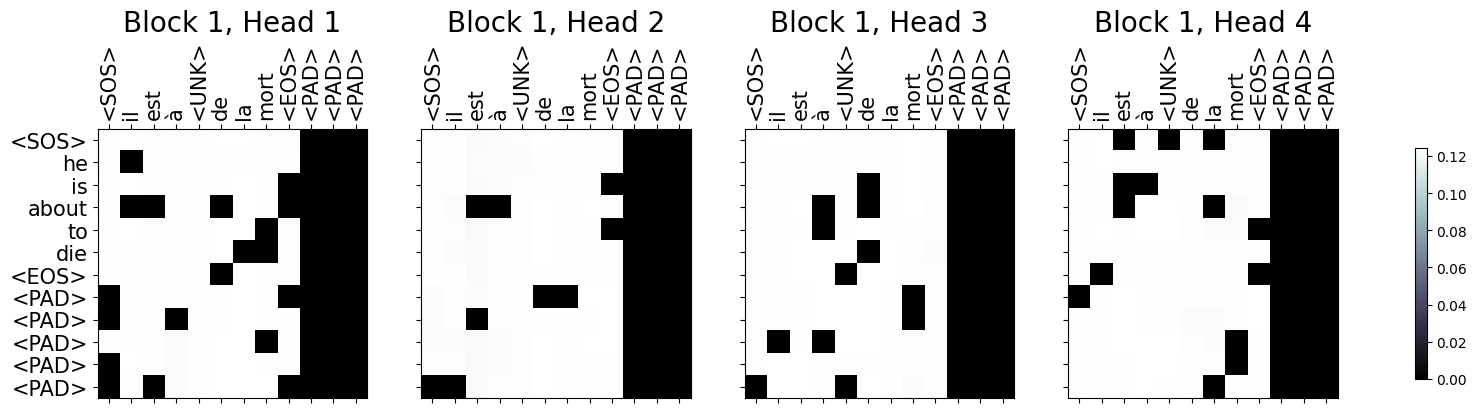

In [106]:
ix = 1
src_sent = src_tok.untokenize(
    X[ix].detach().tolist(), remove_padding_tokens=False
).split()
tgt_sent = tgt_tok.untokenize(
    Y[ix].detach().tolist(), remove_padding_tokens=False
).split()
plot_attention(
    sentence=src_sent, translation=tgt_sent, attention=dec.ed_attn_weights[ix]
)

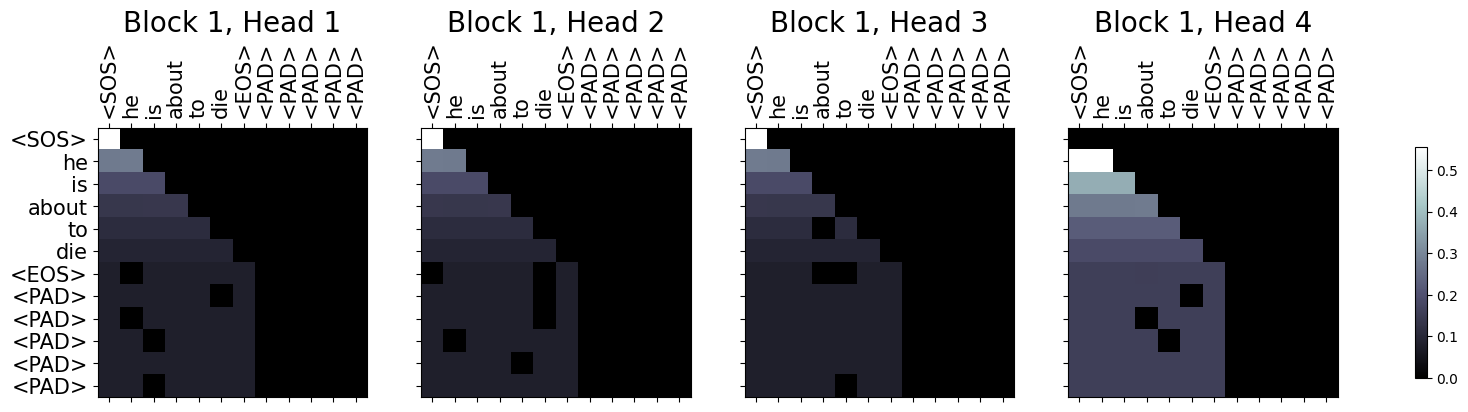

In [107]:
ix = 1
sent = tgt_tok.untokenize(Y[ix].detach().tolist(), remove_padding_tokens=False).split()
plot_attention(sentence=sent, translation=sent, attention=dec.self_attn_weights[ix])

### Transformer

#### Architecture

In [109]:
class TransformerSeq2Seq(nn.Module):
    def __init__(
        self,
        encoder: TransformerEncoder,
        decoder: TransformerDecoder,
    ):
        """
        :param encoder: TransformerEncoder object
        :param decoder: TransformerDecoder object
        """
        super().__init__()
        self.enc = encoder
        self.dec = decoder

    def forward(
        self,
        source: torch.tensor,
        target: torch.tensor,
        src_mask: torch.tensor = None,
        tgt_mask: torch.tensor = None,
    ):
        """
        :param source: (N, T) input tensor
        :param target: (N, T) target tensor
        :param src_mask: (N, T, T) mask tensor for source
        :param tgt_mask: (N, T, T) mask tensor for target
        :return: (N, T, V) predictions
        """
        # Encoder step
        enc_out = self.enc.forward(source, src_mask)  # (N, T, D)
        # Decoder step
        outputs = dec.forward(target, enc_out, src_mask, tgt_mask)  # (N, T, V)

        return outputs

#### Testing the Transformer

In [110]:
# Masked Multi-Head Self-Attention
D, H, E, B = 16, 32, 4, 1
dropout = 0.1
X, Y = next(iter(tiny_train_dl))
N, T = X.shape
src_mask = (X != pad_token_ix).type(torch.long).unsqueeze(1)  # (N, 1, T)
tgt_mask = (Y != pad_token_ix).type(torch.long).unsqueeze(1)  # (N, 1, T)

enc = TransformerEncoder(
    vocab_size=vocab_size,
    emb_size=D,
    head_size=D,
    mlp_hidden_size=H,
    num_heads=E,
    num_blocks=B,
    dropout=dropout,
).to(device)

dec = TransformerDecoder(
    vocab_size=vocab_size,
    emb_size=D,
    head_size=D,
    mlp_hidden_size=H,
    num_heads=E,
    num_blocks=B,
    dropout=dropout,
).to(device)

model = TransformerSeq2Seq(encoder=enc, decoder=dec).to(device)
outputs = model.forward(X, Y, src_mask, tgt_mask)
outputs.shape, outputs.shape == (N, T, vocab_size)

(torch.Size([5, 12, 512]), True)

#### Try to Calculate a Loss Score

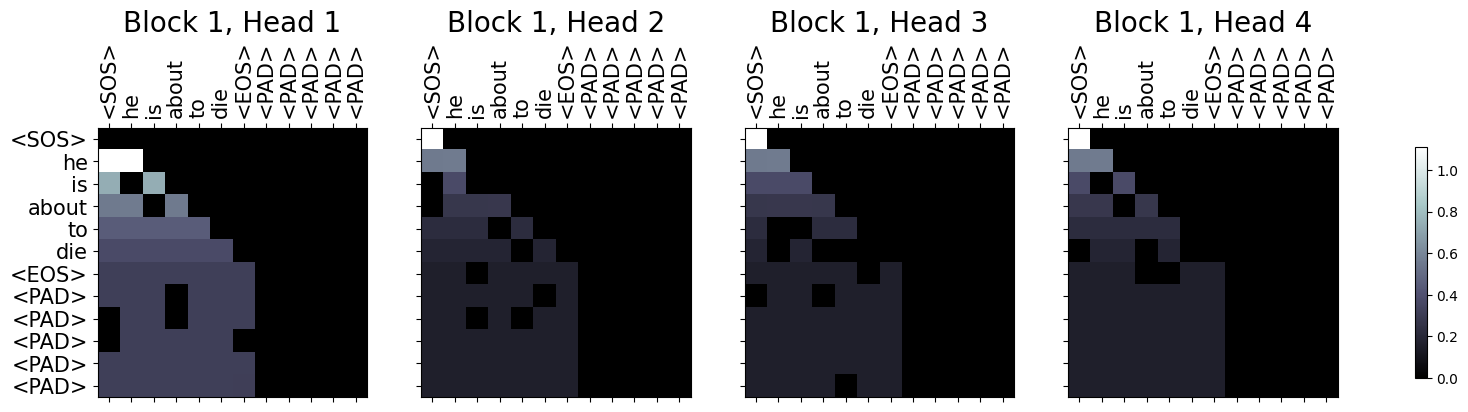

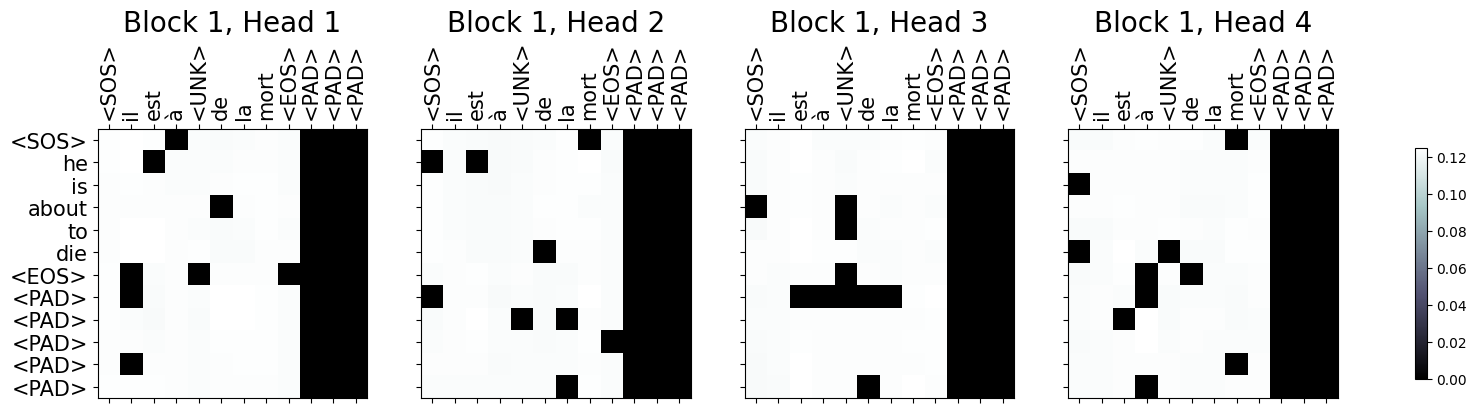

In [111]:
ix = 1
src_sent = src_tok.untokenize(
    X[ix].detach().tolist(), remove_padding_tokens=False
).split()
tgt_sent = tgt_tok.untokenize(
    Y[ix].detach().tolist(), remove_padding_tokens=False
).split()
plot_attention(
    sentence=sent, translation=sent, attention=model.dec.self_attn_weights[ix]
)
plot_attention(
    sentence=src_sent, translation=tgt_sent, attention=model.dec.ed_attn_weights[ix]
)

In [112]:
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_token_ix)

In [113]:
logits = outputs[:, :-1]
targets = Y[:, 1:]
logits.shape, targets.shape

(torch.Size([5, 11, 512]), torch.Size([5, 11]))

In [114]:
loss = loss_fn(logits.reshape(-1, vocab_size), targets.reshape(-1))
loss.item()

6.257051467895508

## Training the Model

In [115]:
def model_forward(
    model,
    source,
    target,
    loss_fn,
    pad_token: int = 0,
):
    # Forward pass - grab the logits that we'll map
    # to probabilities in the loss calculation
    src_mask = (source != pad_token).type(torch.long).unsqueeze(1)  # (N, 1, T)
    tgt_mask = (target != pad_token).type(torch.long).unsqueeze(1)  # (N, 1, T)
    logits = model.forward(
        source=source,
        target=target,
        src_mask=src_mask,
        tgt_mask=tgt_mask,
    )  # (N, T, V)
    _, _, V = logits.shape
    # Logits is the predictions for the next token given the previous tokens
    logits = logits[:, :-1].reshape(-1, V)  # (N*(T-1), V)
    # Targets are the next tokens in the sequence
    target = target[:, 1:].reshape(-1)  # (N*(T-1),)

    # Loss calculation
    loss = loss_fn(logits, target)
    return loss

In [116]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optim,
):
    # Iterate through one epoch-worth of data
    model.train()
    epoch_loss = 0
    # Iterate through the data loader
    for it, batch in enumerate(data_loader):
        optim.zero_grad()

        # Unpack the data loader
        # into source and target sequences
        xb, yb = batch

        # Forward pass - grab the logits that we'll map
        # to probabilities in the loss calculation
        loss = model_forward(model, xb, yb, loss_fn, pad_token=pad_token_ix)
        epoch_loss += loss.item()

        # Backward pass
        loss.backward()

        # Optimization step
        optim.step()

    return epoch_loss / len(data_loader)

In [117]:
@torch.no_grad()
def evaluate_epoch(
    model,
    data_loader,
    loss_fn,
):
    model.eval()
    epoch_loss = 0
    # Iterate through all data in the data loader
    for batch in data_loader:
        # Unpack the data loader
        xb, yb = batch

        # Forward pass_to
        loss = model_forward(model, xb, yb, loss_fn, pad_token=pad_token_ix)
        epoch_loss += loss.item()

    return epoch_loss / len(data_loader)

In [183]:
V, D, H = vocab_size, 256, D * 4
E, B = 2, 2
dropout = 0.1

enc = TransformerEncoder(
    vocab_size=V,
    emb_size=D,
    head_size=D // E,
    mlp_hidden_size=H,
    num_heads=E,
    num_blocks=B,
    dropout=dropout,
)
dec = TransformerDecoder(
    vocab_size=V,
    emb_size=D,
    head_size=D // E,
    mlp_hidden_size=H,
    num_heads=E,
    num_blocks=B,
    dropout=dropout,
)

model = TransformerSeq2Seq(
    encoder=enc,
    decoder=dec,
).to(device)
model.train()

epochs = 10
print_every = 1
optimizer = optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.98), eps=10e-9)
criterion = nn.CrossEntropyLoss(ignore_index=tgt_tok.wtoi[tgt_tok.pad_token])

best_valid_loss = float("inf")
for epoch in tqdm(range(epochs), desc="Epochs"):
    train_loss = train_epoch(
        model=model,
        data_loader=train_dl,
        optim=optimizer,
        loss_fn=criterion,
    )
    val_loss = evaluate_epoch(
        model=model,
        data_loader=val_dl,
        loss_fn=criterion,
    )
    if val_loss < best_valid_loss:
        torch.save(model.state_dict(), "best-model-transformer.pt")
        best_valid_loss = val_loss

    if epoch % print_every == 0 or epoch == epochs - 1:
        print(
            f"({epoch+1}/{epochs})\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}",
            end="",
        )
        print(f"\tValid Loss: {val_loss:7.3f} | Valid PPL: {np.exp(val_loss):7.3f}")

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

(1/10)	Train Loss:   2.995 | Train PPL:  19.984	Valid Loss:   2.215 | Valid PPL:   9.164
(2/10)	Train Loss:   1.964 | Train PPL:   7.131	Valid Loss:   1.768 | Valid PPL:   5.860
(3/10)	Train Loss:   1.519 | Train PPL:   4.569	Valid Loss:   1.573 | Valid PPL:   4.823
(4/10)	Train Loss:   1.224 | Train PPL:   3.400	Valid Loss:   1.389 | Valid PPL:   4.011
(5/10)	Train Loss:   1.023 | Train PPL:   2.781	Valid Loss:   1.349 | Valid PPL:   3.852
(6/10)	Train Loss:   0.879 | Train PPL:   2.408	Valid Loss:   1.325 | Valid PPL:   3.762
(7/10)	Train Loss:   0.786 | Train PPL:   2.194	Valid Loss:   1.317 | Valid PPL:   3.733
(8/10)	Train Loss:   0.701 | Train PPL:   2.016	Valid Loss:   1.372 | Valid PPL:   3.941
(9/10)	Train Loss:   0.636 | Train PPL:   1.889	Valid Loss:   1.322 | Valid PPL:   3.751
(10/10)	Train Loss:   0.594 | Train PPL:   1.811	Valid Loss:   1.337 | Valid PPL:   3.809


In [184]:
model.load_state_dict(torch.load("best-model-transformer.pt"))
test_loss = evaluate_epoch(model, test_dl, criterion)
print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 1.407 | Test PPL:   4.082 |


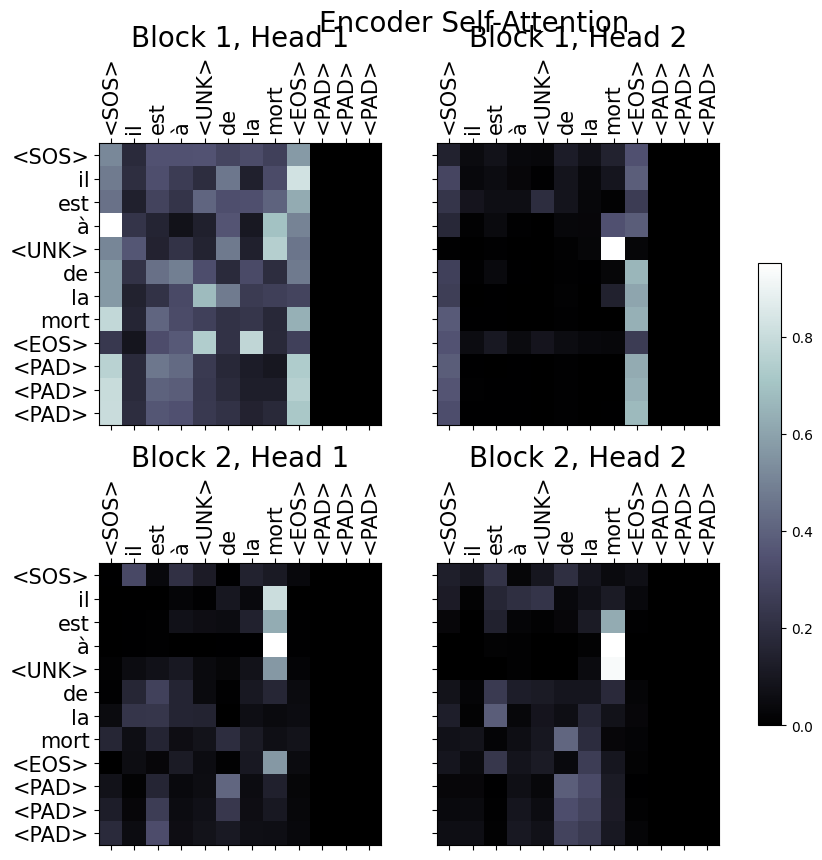

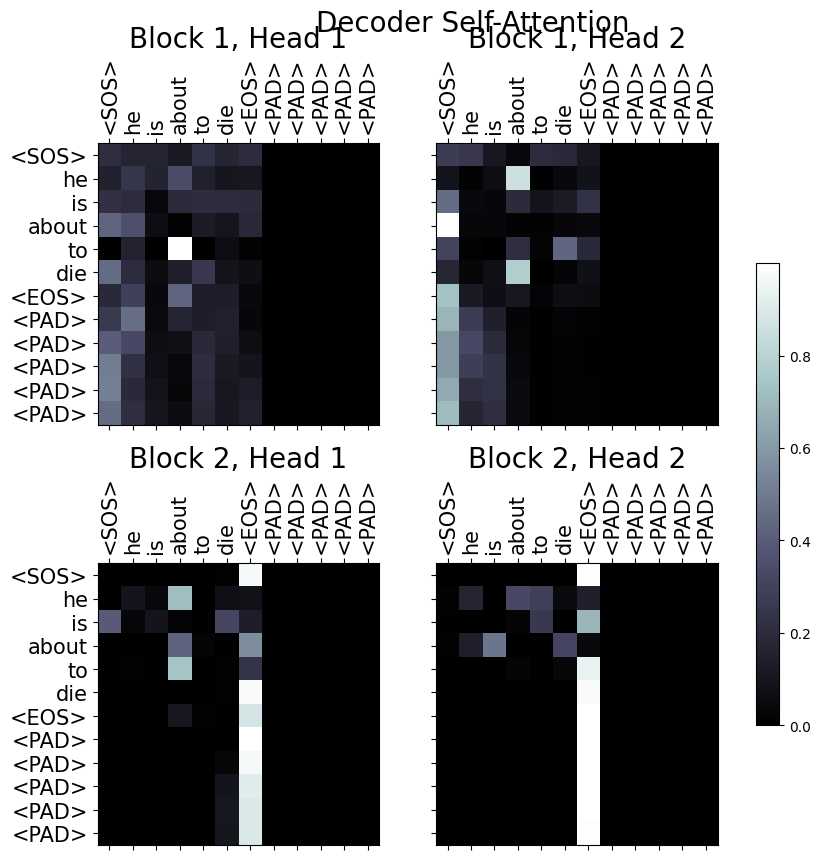

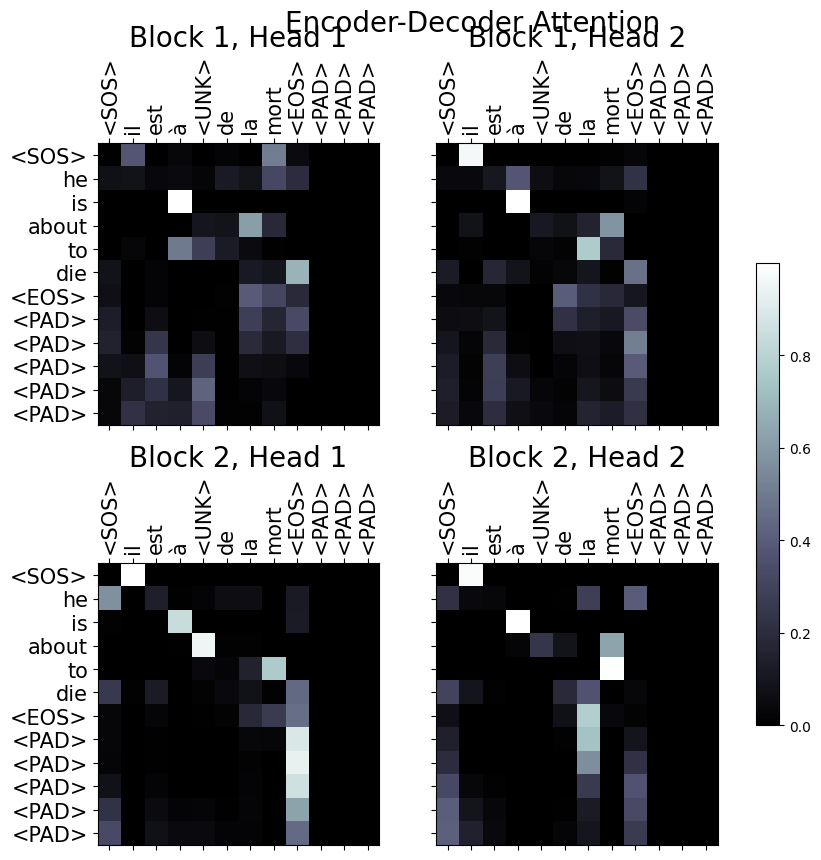

In [185]:
X, Y = next(iter(tiny_train_dl))
src_mask = (X != pad_token_ix).type(torch.long).unsqueeze(1)  # (N, 1, T)
tgt_mask = (Y != pad_token_ix).type(torch.long).unsqueeze(1)  # (N, 1, T)
model.eval()
with torch.no_grad():
    logits = model.forward(
        source=X,
        target=Y,
        src_mask=src_mask,
        tgt_mask=tgt_mask,
    )  # (N, T, V)
model.train()

ix = 1
src_sent = src_tok.untokenize(
    X[ix].detach().tolist(), remove_padding_tokens=False
).split()
tgt_sent = tgt_tok.untokenize(
    Y[ix].detach().tolist(), remove_padding_tokens=False
).split()
plot_attention(
    sentence=src_sent,
    translation=src_sent,
    attention=model.enc.attn_weights[ix],
    title="Encoder Self-Attention",
)
plot_attention(
    sentence=tgt_sent,
    translation=tgt_sent,
    attention=model.dec.self_attn_weights[ix],
    title="Decoder Self-Attention",
)
plot_attention(
    sentence=src_sent,
    translation=tgt_sent,
    attention=model.dec.ed_attn_weights[ix],
    title="Encoder-Decoder Attention",
)

In [186]:
@torch.no_grad()
def translate_sentence(
    sentence,
    model,
    src_tokenizer: Tokenizer,
    tgt_tokenizer: Tokenizer,
    device,
    sos_token: str = "<SOS>",
    eos_token: str = "<EOS>",
    max_output_length: int = 25,
):
    """
    sentence: (T,)
    """
    model.eval()
    sentence = sentence.unsqueeze(0).to(device)  # (1, T)
    src_mask = (sentence != pad_token_ix).type(torch.long).unsqueeze(1)  # (1, 1, T)
    enc_out = model.enc(sentence, src_mask)  # (1, T, D)
    X = torch.tensor(
        [tgt_tokenizer.wtoi[sos_token]], dtype=torch.long, device=device
    ).reshape(1, -1)

    for i in range(max_output_length):
        dec_out = model.dec(X, enc_out)  # (N, T, V)
        logits = dec_out[:, -1]  # (N, V)

        pred_token = logits.argmax(-1).reshape(1, -1)
        X = torch.cat((X, pred_token), dim=1)  # (N, T+1)

        if pred_token.item() == tgt_tokenizer.wtoi[eos_token]:
            break

    tokens = tgt_tok.untokenize(X.squeeze(0).tolist())

    return tokens

In [187]:
X, Y = next(iter(train_dl))

In [188]:
ix = 3
src, tgt = X[ix], Y[ix]
print(src_tok.untokenize(src.tolist()))
print(tgt_tok.untokenize(tgt.tolist()))

<SOS> elle nest pas aussi <UNK> quelle en a lair <EOS>
<SOS> she isnt as stupid as she looks <EOS>


In [189]:
translation = translate_sentence(
    src.to(device),
    model,
    src_tok,
    tgt_tok,
    device,
    max_output_length=tgt_tok.max_length,
)
translation

'<SOS> she is not as a book <EOS>'

In [190]:
src_sent = src_tok.untokenize(
    src.detach().tolist(), remove_padding_tokens=False
).split()
translation = translation.split(" ")[1:]

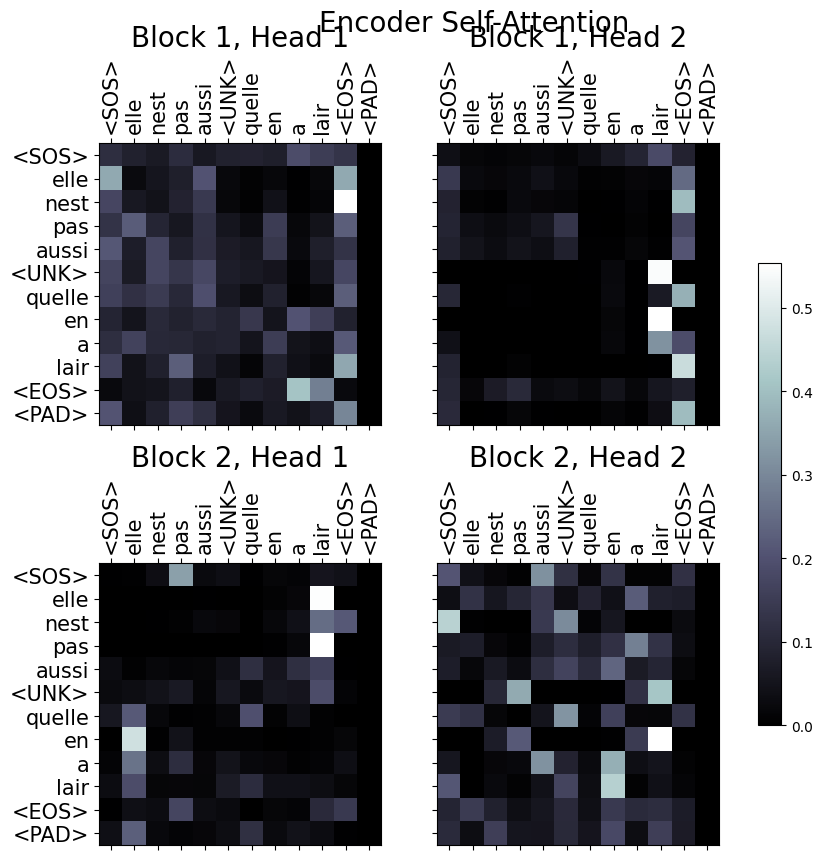

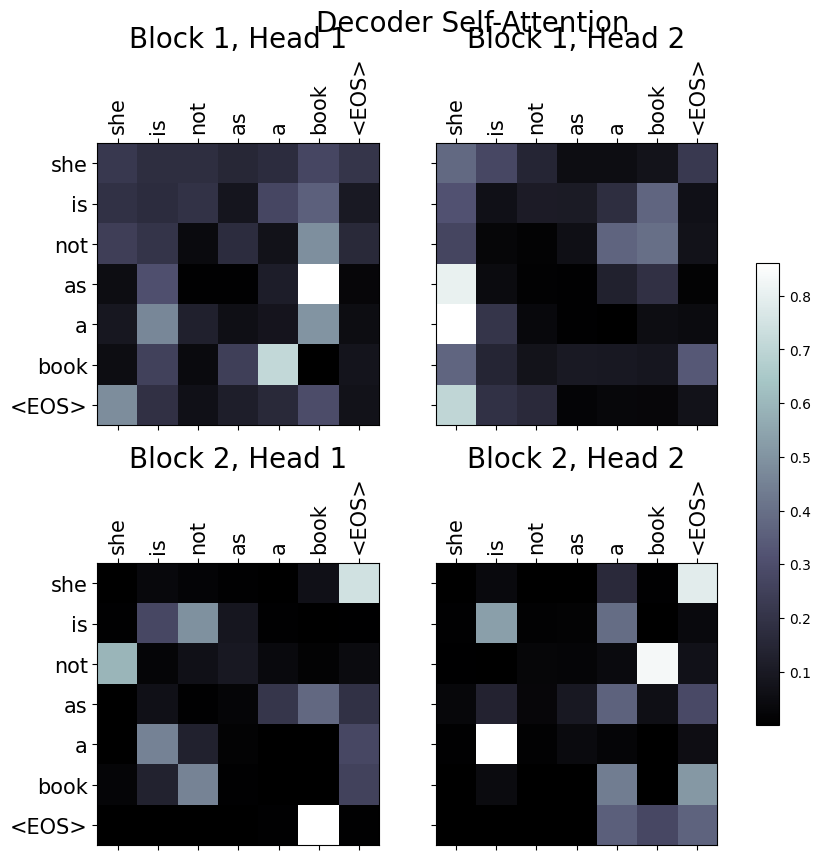

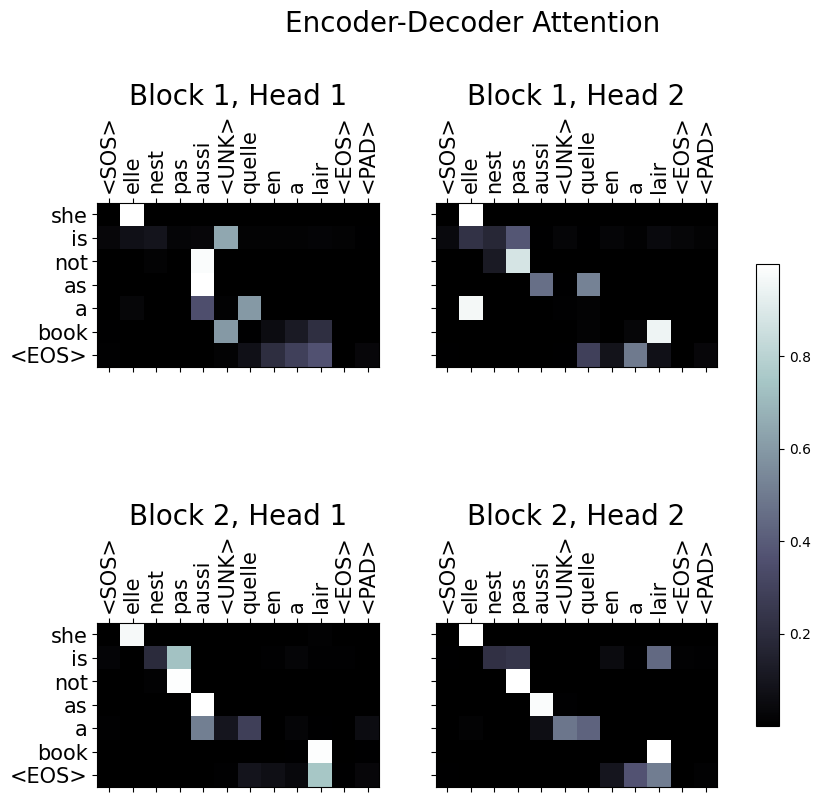

In [191]:
plot_attention(
    sentence=src_sent,
    translation=src_sent,
    attention=model.enc.attn_weights[0],
    title="Encoder Self-Attention",
)
plot_attention(
    sentence=translation,
    translation=translation,
    attention=model.dec.self_attn_weights[0],
    title="Decoder Self-Attention",
)
plot_attention(
    sentence=src_sent,
    translation=translation,
    attention=model.dec.ed_attn_weights[0],
    title="Encoder-Decoder Attention",
)

In [192]:
Xte = torch.tensor([]).type(torch.long).to(device)
Yte = torch.tensor([]).to(device)
for data in test_dl:
    Xte = torch.cat((Xte, data[0]), dim=0)
    Yte = torch.cat((Yte, data[1]), dim=0)
Xte.shape, Yte.shape

(torch.Size([332, 12]), torch.Size([332, 12]))

In [193]:
translations = [
    translate_sentence(
        src,
        model,
        src_tok,
        tgt_tok,
        device,
        max_output_length=tgt_tok.max_length,
    )
    for src in tqdm(Xte)
]

  0%|          | 0/332 [00:00<?, ?it/s]

In [194]:
preds = [" ".join(t.split()[1:-1]) for t in translations]
targets = [[" ".join(tgt_tok.untokenize(t.tolist()).split()[1:-1])] for t in Yte]

In [195]:
ix = 0
preds[0], targets[0]

('we are what we for what we <UNK>', ['you are what you eat'])

In [196]:
bleu = evaluate.load("bleu")

In [197]:
results = bleu.compute(
    predictions=preds, references=targets, tokenizer=lambda x: x.split()
)
results

{'bleu': 0.3434160162981784,
 'precisions': [0.6170986812187358,
  0.43331547937868237,
  0.2768729641693811,
  0.18786367414796343],
 'brevity_penalty': 1.0,
 'length_ratio': 1.1453125,
 'translation_length': 2199,
 'reference_length': 1920}